# Recommendations with IBM

In this notebook, I implemented some techniques on making recommendations using real data from the IBM Watson Studio platform. 

Follow the table of contents to explore the different methods for making recommendations and how they can be used in different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Provides some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [2]:
# Show df to get an idea of the data - contains user-article interactions on the platform, with the user emails anonymized
df.sort_values('email').head()

,article_id,title,email
13865,288.0,"this week in data science (january 31, 2017)",0000b6387a0366322d7fbfc6434af145adf7fed1
4635,1354.0,movie recommender system with spark machine le...,0000b6387a0366322d7fbfc6434af145adf7fed1
16542,618.0,can a.i. be taught to explain itself?,0000b6387a0366322d7fbfc6434af145adf7fed1
7271,1162.0,analyze energy consumption in buildings,0000b6387a0366322d7fbfc6434af145adf7fed1
7363,124.0,python machine learning: scikit-learn tutorial,0000b6387a0366322d7fbfc6434af145adf7fed1


In [3]:
# Show df_content to get an idea of the data - contains article name, description and body, can be linked to df via article ID
df_content.sort_values('article_id').head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
# general overview of both dataframes
print(f'{df.shape}\n\n{df.dtypes}\n\n{df_content.shape}\n\n{df_content.dtypes}')

(45993, 3)

article_id    float64
title          object
email          object
dtype: object

(1056, 5)

doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object


In [5]:
# article hits overall - overview and stats
hits_per_article = df.groupby('article_id')['email'].count()
mean_hits = hits_per_article.mean()
median_hits = hits_per_article.median()
max_hits = hits_per_article.max()
min_hits = hits_per_article.min()

print(f'average interactions per article: {mean_hits} \nmaximum interactions per article: {max_hits} \nminimum interactions per article: {min_hits}\nmedian: 50% of articles are interacted with {median_hits} times or fewer ')

average interactions per article: 64.3921568627451 
maximum interactions per article: 937 
minimum interactions per article: 1
median: 50% of articles are interacted with 25.0 times or fewer 


In [6]:
# user interactions: article hits per user - overview and stats
hits_per_user = df.groupby('email')['article_id'].count()
mean_art = hits_per_user.mean()
median_art = hits_per_user.median()
max_art = hits_per_user.max()
min_art = hits_per_user.min()

print(f'average interactions by any single user: {mean_art} \nmaximum interactions by any single user: {max_art} \nminimum interactions by any single user: {min_art}\nmedian: 50% of users are interacted with {median_art} articles or fewer ')

average interactions by any single user: 8.930846930846931 
maximum interactions by any single user: 364 
minimum interactions by any single user: 1
median: 50% of users are interacted with 3.0 articles or fewer 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbee6848f28>]], dtype=object)

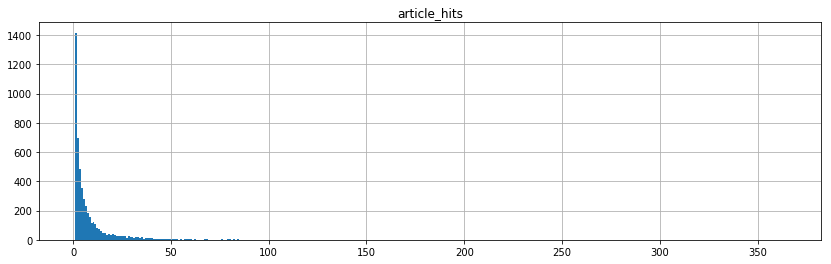

In [7]:
# article hits per user distribution - histogram
hits_df = pd.DataFrame(hits_per_user).rename(columns={'article_id': 'article_hits'})
hits_df.hist(grid=True, bins=364, figsize=(14,4))

In [8]:
# article hits per user - KDE distribution function and box plot
# hits_df['article_hits'].plot.box()
# hits_df['article_hits'].plot.kde()

In [9]:
# Fill in the median and maximum number of user_article interactions below
median_val = median_art 
max_views_by_user = max_art 

print(f'50% of individuals interact with this number of articles or fewer: {median_val}\n\
The maximum number of user-article interactions by any 1 user is: {max_views_by_user}')

50% of individuals interact with this number of articles or fewer: 3.0
The maximum number of user-article interactions by any 1 user is: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles - check for duplicates in all columns
df_content.drop_duplicates(inplace=True)
# Remove any rows that have the same article_id - subset to id's and only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True) 

print(f'df shape without duplicates {df_content.shape}')

df shape without duplicates (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have at least one interaction (=unique articles in the interactions df)
unique_articles = df['article_id'].nunique()

# The number of unique articles on the IBM platform (=unique articles in the content df)
total_articles = df_content['article_id'].nunique()

# The number of unique users (=unique users in the interactions df)
unique_users = df['email'].nunique()

# The number of user-article interactions (=non-NaN rows in interactions df)
user_article_interactions = df.shape[0]

print(f'total number of unique articles: {total_articles}\n\
number of articles having been interacted with: {unique_articles}\n\
unique users on the platform: {unique_users}\n\
user-article interactions recorded in the dataset: {user_article_interactions}')

total number of unique articles: 1051
number of articles having been interacted with: 714
unique users on the platform: 5148
user-article interactions recorded in the dataset: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
most_viewed_article_id = str(hits_per_article.sort_values(ascending=False).index[0])
max_views = hits_per_article.sort_values(ascending=False).values[0]

print(f'The most viewed article in the dataset has the ID {most_viewed_article_id} and was viewed {max_views} times')

The most viewed article in the dataset has the ID 1429.0 and was viewed 937 times


In [13]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_idx = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index[:n]
    
    top_articles = []
    for i in list(top_idx):
        top_articles.append(df[df['article_id'] == i]['title'].unique()[0])
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_idx = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index[:n]
 
    return list(top_idx)

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # unstack dataframe
    user_item = df.groupby(['user_id', 'article_id']).max().unstack()
    
    # convert entries into 0/1
    user_item = user_item.notna().astype('int')
    
    # drop multilevel index with title
    user_item.columns = user_item.columns.droplevel()
    
    # return the user_item matrix
    return user_item

user_item = create_user_item_matrix(df)

In [19]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user:
    # get all user ids
    all_users = np.array(user_item.index)
    # select the provided user
    user_row = user_item.loc[user_id, :]
    # get similar users to provided user by dot product
    sim_users = np.dot(user_row, np.transpose(user_item))
    # save similar users and their ids in Dataframe
    similarity = pd.DataFrame({'user_id': all_users, 'similarity': sim_users})
    
    # sort by similarity
    similarity.sort_values('similarity', ascending=False, inplace=True)

    # create list of just the ids
    ids = list(similarity['user_id'])
   
    # remove the own user's id
    ids.remove(user_id)
    
    most_similar_users = ids
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # convert string list entries to floats if necessary
    article_ids = [float(i) for i in article_ids]
    
    article_names = [df[df['article_id'] == i]['title'].unique()[0] for i in article_ids]
    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # interactions for the provided user
    user_row = user_item.loc[user_id, :]
    
    # filter for articles read by the user
    articles_read = user_row[user_row > 0]
    
    # get article ids from index
    article_ids = list(articles_read.index)
    
    # get article names with get_article_names function
    article_names = get_article_names(article_ids, df=df)
    
#     return article_ids, article_names # return the ids and names
    return [str(i) for i in article_ids], article_names # return the ids and names as strings


def user_user_recs(user_id, m=10, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each neighouring user - finds articles the provided user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # get the articles the provided user has already seen
    seen_ids, seen_names = get_user_articles(user_id=user_id)
    
    # get the ids of most similar users (closest neighbours) to the provided user
    most_similar_users = find_similar_users(user_id=user_id)
    
    # initialize recommendations list for article ids
    recs = []
    
    # provide articles the user hasn't seen before as recommendations based on what the user's neighbours have seen:
    for neighbour_id in most_similar_users:
        # get the articles each neighbour has already seen
        nb_seen_ids, nb_seen_names = get_user_articles(user_id=neighbour_id)
        # drop those which the provided user has already seen as well...
        new_articles = [x for x in nb_seen_ids if x not in seen_ids]
        # ... and append remaining articles to the recommendations list, if they are not in there already...
        for article in new_articles:
            if not article in recs:
                recs.append(article)
        # ...until at least m recommendations have been found
        if len(recs) > m-1:
                break
        
    # pick top m recommendations from list
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # get all user ids
    all_users = np.array(user_item.index)

    # select the provided user
    user_row = user_item.loc[user_id, :]

    # compute similarity as dot product of two users (similarity = measure of how many articles they both interacted with)
    sim_users = np.dot(user_row, np.transpose(user_item))

    # save similar users and their ids in Dataframe
    sim = pd.DataFrame({'neighbor_id': all_users, 'similarity_total': sim_users})

    # normalize similarity with the similarity the user has with himself
    sim_self = sim[sim['neighbor_id'] == user_id]['similarity_total'].values
    sim['similarity'] = sim_users/sim_self

    # add number of interactions each neighbouring user has
    sim['num_interactions']= df.groupby('user_id').count()['article_id'].values
    
    # sort by similarity and number of interactions
    neighbors_df = sim.sort_values(['similarity', 'num_interactions'], ascending = False)
    
    # remove entry with the privided user himself
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get the articles the provided user has already seen
    seen_ids, seen_names = get_user_articles(user_id=user_id)
    
    # get the ids of most similar users to the provided user - based on similarity AND number of interactions
    most_similar_users = list(get_top_sorted_users(user_id=user_id)['neighbor_id'])
    
    # initialize recommendations list for article ids
    recs = []
    
    # provide articles the user hasn't seen before as recommendations based on what the user's neighbours have seen:
    for neighbour_id in most_similar_users:
        # get list of articles each neighbour has already seen...
        nb_seen_ids, nb_seen_names = get_user_articles(user_id=neighbour_id)
        
        # ...and sort these articles by the number of total user interactions they have
        top_articles = df.groupby('article_id').count()['user_id'].sort_values(ascending=False)
        
        nb_seen_ids_sorted = list(top_articles[top_articles.index.isin(nb_seen_ids)].index)
        
        # drop those which the provided user has already seen as well...
        new_articles = [x for x in nb_seen_ids_sorted if x not in seen_ids]
        # ... and append remaining articles to the recommendations list, if they are not in there already...
        for article in new_articles:
            if not article in recs:
                recs.append(article)
        # ...until at least m recommendations have been found
        if len(recs) > m-1:
                break
        
    # pick top m recommendations from list
    recs = recs[:m]
    
    # get top recommendation article names
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [28]:
user1_most_sim = get_top_sorted_users(user_id=1)
user1_most_sim.head(n=1)

,neighbor_id,similarity_total,similarity,num_interactions
3932,3933,35,0.972222,45


In [29]:
user1_most_sim = get_top_sorted_users(user_id=131)
user1_most_sim.head(n=11)

,neighbor_id,similarity_total,similarity,num_interactions
3869,3870,74,0.986667,144
3781,3782,39,0.520000,363
22,23,38,0.506667,364
202,203,33,0.440000,160
4458,4459,33,0.440000,158
97,98,29,0.386667,170
3763,3764,29,0.386667,169
48,49,29,0.386667,147
3696,3697,29,0.386667,145
241,242,25,0.333333,148


In [30]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [31]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**A new user would not have any interactions with articles yet, so we cannot make recommendations based on the collaboration of user-item pairs. Both the neighbourhood based and model based approaches would fail in this case of a cold start problem.**

**We would thus either just recommend the most popular (=most interacted with) articles or resort to a content based approach for new users.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [32]:
# recommend rank-based: top articles

new_user = '0.0'

top_articles = df.groupby('article_id').count()['user_id'].sort_values(ascending=False)

recs = [str(i) for i in list(top_articles.head(n=10).index)] 

new_user_recs = recs

In [33]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [36]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

print(u.shape, s.shape, vt.shape)
# use the built in to get the three matrices

(5149, 5149) (714,) (714, 714)


**During the lesson, we had ratings in the user-item matrix, so the cells could either take on a rating value (i.e. 0-10) or contain "NaN", if the user did not give a rating (or did not see the movie yet).**

**Here, the user-item matrix contains only binary values of 0 and 1, based on whether there was a user-item interaction or not - hence, this matrix is not sparse and we can perform traditional SVD.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

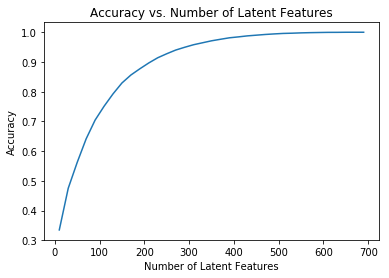

In [37]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [38]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # user-item matrices for training and test datasets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # test user and article id's
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [39]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [40]:
# cold start problem, user based:
# how many users are in test, but NOT in training dataset (i.e. which users don't we have any previous interactions from)?
usr_cold = [usr for usr in test_idx if usr not in list(user_item_train.index)]

# how many users are in both datasets?
usr_ok = list(set(test_idx) & set(list(user_item_train.index)))

In [41]:
len(usr_ok), len(usr_cold)

(20, 662)

In [42]:
# cold start problem, article based:
# how many articles are in test, but NOT in training dataset (i.e. which articles don't we have any previous interactions from)?
art_cold = [art for art in test_arts if art not in list(user_item_train.columns)]

# how many articles are in both datasets?
art_ok = list(set(test_arts) & set(list(user_item_train.columns)))

In [43]:
len(art_ok), len(art_cold)

(574, 0)

In [44]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [45]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [46]:
# subset these matrices to user_item_test dataset we can actually predict to avoid cold start problem
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
s_test = s_train

print(u_test.shape, s_test.shape, vt_test.shape)

(20, 4487) (714,) (714, 574)


In [47]:
# subset user_item_test dataset to the rows we can actually predict to avoid cold start problem
user_item_test_sub = user_item_test[user_item_test.index.isin(usr_ok)]

user_item_test_sub.shape, user_item_train.shape

((20, 574), (4487, 714))

In [48]:
# get some more info about the test subset
possible_inter = user_item_test_sub.shape[0]*user_item_test_sub.shape[1]
actual_inter = user_item_test_sub[user_item_test_sub > 0].count().sum()
no_inter = user_item_test_sub[user_item_test_sub == 0].count().sum()

print(f'Out of {possible_inter} possible user-article interactions in the test subset, \
the user-item-matrix contains {actual_inter} actual interactions and {no_inter} cells where no interaction took place. \
\n\n\
This indicates that the test dataset is very imbalanced.')

Out of 11480 possible user-article interactions in the test subset, the user-item-matrix contains 218 actual interactions and 11262 cells where no interaction took place. 

This indicates that the test dataset is very imbalanced.


In [49]:
# assess prediction with different numbers of latent features
from sklearn import metrics

num_latent_feats = np.arange(10,710,20)

sum_errs_train, sum_errs_test = [], []
sum_f1_train, sum_f1_test = [], []

for k in num_latent_feats:
    
    # restructure training and test sets with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = np.diag(s_test[:k]), u_test[:, :k], vt_test[:k, :]
    
    # take dot products to make predictions on training and test datasets
    pred_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    pred_test = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))

    # compute error for each prediction to actual value in the training and test datasets
    diffs_train = np.subtract(user_item_train, pred_train)
    diffs_test = np.subtract(user_item_test_sub, pred_test)
    

    # total absolute errors in training and test datasets
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    # compute weighted f1 score as a second measure for accuracy on unbalanced dataset
    f1_train = metrics.f1_score(np.array(user_item_train).flatten(), pred_train.flatten(), average='weighted', labels=[1.0])
    f1_test = metrics.f1_score(np.array(user_item_test_sub).flatten(), pred_test.flatten(), average='weighted', labels=[1.0])
    sum_f1_train.append(f1_train)
    sum_f1_test.append(f1_test)

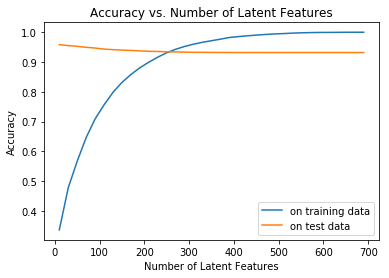

In [50]:
# plot accuracy in terms of absolute error
train_line = plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df_train.shape[0], label='on training data')
test_line = plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df_test.shape[0], label='on test data')

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.legend(loc = 'best')
plt.title('Accuracy vs. Number of Latent Features');

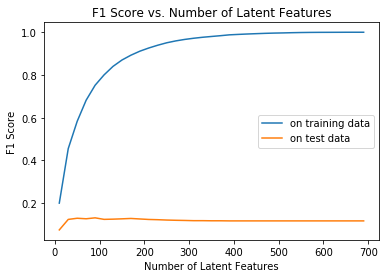

In [51]:
# plot f1 score
train_line = plt.plot(num_latent_feats, sum_f1_train, label='on training data')
test_line = plt.plot(num_latent_feats, sum_f1_test, label='on test data')

plt.xlabel('Number of Latent Features');
plt.ylabel('F1 Score');
plt.legend(loc = 'best')
plt.title('F1 Score vs. Number of Latent Features');

In [52]:
# get some more info about the prediction
pred_test_df = pd.DataFrame(pred_test)

possible_inter = pred_test_df.shape[0] * pred_test_df.shape[1]
actual_inter = pred_test_df[pred_test_df > 0].count().sum()
no_inter = pred_test_df[pred_test_df == 0].count().sum()

pred_acc = 1 - np.array(sum_errs_test)/df_test.shape[0]
acc_10 = pred_acc[0]
acc_end = pred_acc[-1]

print(f'Out of {possible_inter} possible user-article interactions in the prediction, \
the prediction contains {actual_inter} actual interactions and {no_inter} cells where no interaction took place. \
\n\n\
This leads to an estimation accuracy of {acc_end} if all latent features are used for the prediction, \
compared to {acc_10} when only 10 latent features are used')

Out of 11480 possible user-article interactions in the prediction, the prediction contains 244 actual interactions and 11236 cells where no interaction took place. 

This leads to an estimation accuracy of 0.9319205740030035 if all latent features are used for the prediction, compared to 0.9586183881194728 when only 10 latent features are used


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**For the training dataset, the prediction accuracy increases with the number of latent features, with the curve flattening for more than half of the latent features used. The prediction accuracy for the test dataset decreases slightly with the number of latent features used. The test F1 score initially improves, but then also decreases, being overall very low.**

**Hence, we might want to resort to a mix of methods for making recommendations to users, i.e. rank based recommendations for new users and a mix of collaboration and content based recommendations elsewhere. For the latter, we could for example make use of the df_content table, searching for similarities of the articles based on title and description**

**All methods used here are based purely on user-article interactions, assuming that articles which are often read are also very popular. We do not know whether a user followed a recommendation initially but then ended up not liking or reading it completely.**

**In order to validate this assumption (or any of the discussed recommendation approach), we could implement different types of experiments with A/B user groups from the actual IBM platform.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])